In [ ]:
#LM-O
output_dir = '/Workspace/Data/Example/outputs'
cad_path = '/Workspace/Data/Example/obj_000005.ply'
rgb_path = '/Workspace/Data/Example/rgb.png'
depth_path = '/Workspace/Data/Example/depth.png'
cam_path = '/Workspace/Data/Example/camera.json'
seg_path = '/Workspace/Data/Example/outputs/sam6d_results/detection_ism.json'

In [ ]:
#YCBV
output_dir = '/Workspace/Data/Example_ycbv/outputs'
cad_path = '/Workspace/Data/Example_ycbv/obj_000015.ply'
rgb_path = '/Workspace/Data/Example_ycbv/rgb.png'
depth_path = '/Workspace/Data/Example_ycbv/depth.png'
cam_path = '/Workspace/Data/Example_ycbv/camera.json'
seg_path = '/Workspace/Data/Example_ycbv/outputs/sam6d_results/detection_ism.json'

In [1]:
#TLESS
output_dir = '/Workspace/Data/Example_tless/outputs'
cad_path = '/Workspace/Data/Example_tless/obj_000005.ply'
rgb_path = '/Workspace/Data/Example_tless/rgb.png'
depth_path = '/Workspace/Data/Example_tless/depth.png'
cam_path = '/Workspace/Data/Example_tless/camera.json'
seg_path = '/Workspace/Data/Example_tless/outputs/sam6d_results/detection_ism.json'

In [2]:
det_score_thresh = 0.2

In [3]:
import argparse
import cv2
import gorilla
import importlib
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp
import pycocotools.mask as cocomask
import random
import sys
import torch
import torchvision.transforms as transforms
import trimesh

In [4]:
ROOT_DIR = '/code/SAM-6D/Pose_Estimation_Model'
sys.path.append(os.path.join(ROOT_DIR, 'provider'))
sys.path.append(os.path.join(ROOT_DIR, 'utils'))
sys.path.append(os.path.join(ROOT_DIR, 'model'))
sys.path.append(os.path.join(ROOT_DIR, 'model', 'pointnet2'))

In [5]:
from data_utils import (
    load_im,
    get_bbox,
    get_point_cloud_from_depth,
    get_resize_rgb_choose,
)
from draw_utils import draw_detections
from PIL import Image

In [6]:
args_model = 'pose_estimation_model'
args_config = '/code/SAM-6D/Pose_Estimation_Model/config/base.yaml'
args_iter = 600000
args_exp_id = 0
args_gpus = '0'

In [7]:
exp_name = args_model + '_' + \
    osp.splitext(args_config.split("/")[-1])[0] + '_id' + str(args_exp_id)
log_dir = osp.join("log", exp_name)

In [8]:
cfg = gorilla.Config.fromfile(args_config)
cfg.exp_name = exp_name
cfg.gpus     = args_gpus
cfg.model_name = args_model
cfg.log_dir  = log_dir
cfg.test_iter = args_iter

cfg.output_dir = output_dir
cfg.cad_path = cad_path
cfg.rgb_path = rgb_path
cfg.depth_path = depth_path
cfg.cam_path = cam_path
cfg.seg_path = seg_path

cfg.det_score_thresh = det_score_thresh
gorilla.utils.set_cuda_visible_devices(gpu_ids = cfg.gpus)

set CUDA_VISIBLE_DEVICES as 0


In [9]:
rgb_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])])

In [10]:
def visualize(rgb, pred_rot, pred_trans, model_points, K, save_path):
    img = draw_detections(rgb, pred_rot, pred_trans, model_points, K, color=(255, 0, 0))
    img = Image.fromarray(np.uint8(img))
    img.save(save_path)
    prediction = Image.open(save_path)
    
    # concat side by side in PIL
    rgb = Image.fromarray(np.uint8(rgb))
    img = np.array(img)
    concat = Image.new('RGB', (img.shape[1] + prediction.size[0], img.shape[0]))
    concat.paste(rgb, (0, 0))
    concat.paste(prediction, (img.shape[1], 0))
    return concat

In [11]:
def _get_template(path, cfg, tem_index=1):
    rgb_path = os.path.join(path, 'rgb_'+str(tem_index)+'.png')
    mask_path = os.path.join(path, 'mask_'+str(tem_index)+'.png')
    xyz_path = os.path.join(path, 'xyz_'+str(tem_index)+'.npy')

    rgb = load_im(rgb_path).astype(np.uint8)
    xyz = np.load(xyz_path).astype(np.float32) / 1000.0  
    mask = load_im(mask_path).astype(np.uint8) == 255

    bbox = get_bbox(mask)
    y1, y2, x1, x2 = bbox
    mask = mask[y1:y2, x1:x2]

    rgb = rgb[:,:,::-1][y1:y2, x1:x2, :]
    if cfg.rgb_mask_flag:
        rgb = rgb * (mask[:,:,None]>0).astype(np.uint8)

    rgb = cv2.resize(rgb, (cfg.img_size, cfg.img_size), interpolation=cv2.INTER_LINEAR)
    rgb = rgb_transform(np.array(rgb))

    choose = (mask>0).astype(np.float32).flatten().nonzero()[0]
    if len(choose) <= cfg.n_sample_template_point:
        choose_idx = np.random.choice(np.arange(len(choose)), cfg.n_sample_template_point)
    else:
        choose_idx = np.random.choice(np.arange(len(choose)), cfg.n_sample_template_point, replace=False)
    choose = choose[choose_idx]
    xyz = xyz[y1:y2, x1:x2, :].reshape((-1, 3))[choose, :]

    rgb_choose = get_resize_rgb_choose(choose, [y1, y2, x1, x2], cfg.img_size)
    return rgb, rgb_choose, xyz

In [12]:
def get_templates(path, cfg):
    n_template_view = cfg.n_template_view
    all_tem = []
    all_tem_choose = []
    all_tem_pts = []

    total_nView = 42
    for v in range(n_template_view):
        i = int(total_nView / n_template_view * v)
        tem, tem_choose, tem_pts = _get_template(path, cfg, i)
        all_tem.append(torch.FloatTensor(tem).unsqueeze(0).cuda())
        all_tem_choose.append(torch.IntTensor(tem_choose).long().unsqueeze(0).cuda())
        all_tem_pts.append(torch.FloatTensor(tem_pts).unsqueeze(0).cuda())
    return all_tem, all_tem_pts, all_tem_choose

In [13]:
def get_test_data(rgb_path, depth_path, cam_path, cad_path, seg_path, det_score_thresh, cfg):
    dets = []
    with open(seg_path) as f:
        dets_ = json.load(f) # keys: scene_id, image_id, category_id, bbox, score, segmentation
    for det in dets_:
        if det['score'] > det_score_thresh:
            dets.append(det)
    del dets_

    cam_info = json.load(open(cam_path))
    K = np.array(cam_info['cam_K']).reshape(3, 3)

    whole_image = load_im(rgb_path).astype(np.uint8)
    if len(whole_image.shape)==2:
        whole_image = np.concatenate([whole_image[:,:,None], whole_image[:,:,None], whole_image[:,:,None]], axis=2)
    whole_depth = load_im(depth_path).astype(np.float32) * cam_info['depth_scale'] / 1000.0
    whole_pts = get_point_cloud_from_depth(whole_depth, K)

    mesh = trimesh.load_mesh(cad_path)
    model_points = mesh.sample(cfg.n_sample_model_point).astype(np.float32) / 1000.0
    radius = np.max(np.linalg.norm(model_points, axis=1))

    all_rgb = []
    all_cloud = []
    all_rgb_choose = []
    all_score = []
    all_dets = []
    for inst in dets:
        seg = inst['segmentation']
        score = inst['score']

        # mask
        h,w = seg['size']
        try:
            rle = cocomask.frPyObjects(seg, h, w)
        except:
            rle = seg
        mask = cocomask.decode(rle)
        mask = np.logical_and(mask > 0, whole_depth > 0)
        if np.sum(mask) > 32:
            bbox = get_bbox(mask)
            y1, y2, x1, x2 = bbox
        else:
            continue
        mask = mask[y1:y2, x1:x2]
        choose = mask.astype(np.float32).flatten().nonzero()[0]

        # pts
        cloud = whole_pts.copy()[y1:y2, x1:x2, :].reshape(-1, 3)[choose, :]
        center = np.mean(cloud, axis=0)
        tmp_cloud = cloud - center[None, :]
        flag = np.linalg.norm(tmp_cloud, axis=1) < radius * 1.2
        if np.sum(flag) < 4:
            continue
        choose = choose[flag]
        cloud = cloud[flag]

        if len(choose) <= cfg.n_sample_observed_point:
            choose_idx = np.random.choice(np.arange(len(choose)), cfg.n_sample_observed_point)
        else:
            choose_idx = np.random.choice(np.arange(len(choose)), cfg.n_sample_observed_point, replace=False)
        choose = choose[choose_idx]
        cloud = cloud[choose_idx]

        # rgb
        rgb = whole_image.copy()[y1:y2, x1:x2, :][:,:,::-1]
        if cfg.rgb_mask_flag:
            rgb = rgb * (mask[:,:,None]>0).astype(np.uint8)
        rgb = cv2.resize(rgb, (cfg.img_size, cfg.img_size), interpolation=cv2.INTER_LINEAR)
        rgb = rgb_transform(np.array(rgb))
        rgb_choose = get_resize_rgb_choose(choose, [y1, y2, x1, x2], cfg.img_size)

        all_rgb.append(torch.FloatTensor(rgb))
        all_cloud.append(torch.FloatTensor(cloud))
        all_rgb_choose.append(torch.IntTensor(rgb_choose).long())
        all_score.append(score)
        all_dets.append(inst)

    ret_dict = {}
    ret_dict['pts'] = torch.stack(all_cloud).cuda()
    ret_dict['rgb'] = torch.stack(all_rgb).cuda()
    ret_dict['rgb_choose'] = torch.stack(all_rgb_choose).cuda()
    ret_dict['score'] = torch.FloatTensor(all_score).cuda()

    ninstance = ret_dict['pts'].size(0)
    ret_dict['model'] = torch.FloatTensor(model_points).unsqueeze(0).repeat(ninstance, 1, 1).cuda()
    ret_dict['K'] = torch.FloatTensor(K).unsqueeze(0).repeat(ninstance, 1, 1).cuda()
    return ret_dict, whole_image, whole_pts.reshape(-1, 3), model_points, all_dets

In [14]:
random.seed(cfg.rd_seed)
torch.manual_seed(cfg.rd_seed)

In [15]:
# model
print("=> creating model ...")
MODEL = importlib.import_module(cfg.model_name)
model = MODEL.Net(cfg.model)
model = model.cuda()
model.eval()
checkpoint = '/code/SAM-6D/Pose_Estimation_Model/checkpoints/sam-6d-pem-base.pth'
gorilla.solver.load_checkpoint(model=model, filename=checkpoint)

=> creating model ...
load pre-trained checkpoint from: checkpoints/mae_pretrain_vit_base.pth


{'meta': {'iter': 600000, 'epoch': 15, 'time': 'Sun Jan 21 23:50:39 2024'},
 'model': OrderedDict([('feature_extraction.rgb_net.vit.cls_token',
               tensor([[[ 5.6829e-03, -3.4927e-02, -3.3085e-03,  1.6084e-02, -7.3597e-03,
                         -2.6187e-02, -4.1245e-02, -1.7340e-01,  3.3176e-02, -1.5807e-02,
                         -3.8766e-03, -9.9360e-02, -1.2822e-01,  1.1953e-02,  3.6924e-02,
                         -5.1167e-02, -2.1221e-02,  1.2517e-02,  9.0331e-03,  2.2728e-02,
                          7.3010e-02,  3.3429e-03,  2.2205e-02,  1.4979e-02, -3.7898e-02,
                         -2.7482e-02, -3.1720e-02, -1.7766e-02,  2.3728e-03,  9.0945e-03,
                         -1.1188e-02, -9.2082e-03, -1.3281e-01, -1.3771e-02, -2.3379e-02,
                         -8.1468e-02, -1.1608e-02, -3.2783e-04,  9.1092e-03, -2.2964e-02,
                          2.0785e-02,  1.1653e-02,  1.2789e-02, -2.3947e-03,  7.5335e-02,
                          1.0217e-02,  1.5693e

In [16]:
print("=> extracting templates ...")
tem_path = os.path.join(cfg.output_dir, 'templates')
all_tem, all_tem_pts, all_tem_choose = get_templates(tem_path, cfg.test_dataset)
with torch.no_grad():
    all_tem_pts, all_tem_feat = model.feature_extraction.get_obj_feats(all_tem, all_tem_pts, all_tem_choose)

=> extracting templates ...


In [17]:
print("=> loading input data ...")
input_data, img, whole_pts, model_points, detections = get_test_data(
    cfg.rgb_path, cfg.depth_path, cfg.cam_path, cfg.cad_path, cfg.seg_path, 
    cfg.det_score_thresh, cfg.test_dataset
)
ninstance = input_data['pts'].size(0)

=> loading input data ...


In [18]:
print("=> running model ...")
with torch.no_grad():
    input_data['dense_po'] = all_tem_pts.repeat(ninstance,1,1)
    input_data['dense_fo'] = all_tem_feat.repeat(ninstance,1,1)
    out = model(input_data)

if 'pred_pose_score' in out.keys():
    pose_scores = out['pred_pose_score'] * out['score']
else:
    pose_scores = out['score']
pose_scores = pose_scores.detach().cpu().numpy()
pred_rot = out['pred_R'].detach().cpu().numpy()
pred_trans = out['pred_t'].detach().cpu().numpy() * 1000

=> running model ...


In [19]:
print("=> saving results ...")
os.makedirs(f"{cfg.output_dir}/sam6d_results", exist_ok=True)
for idx, det in enumerate(detections):
    detections[idx]['score'] = float(pose_scores[idx])
    detections[idx]['R'] = list(pred_rot[idx].tolist())
    detections[idx]['t'] = list(pred_trans[idx].tolist())

with open(os.path.join(f"{cfg.output_dir}/sam6d_results", 'detection_pem.json'), "w") as f:
    json.dump(detections, f)

=> saving results ...


In [20]:
print("=> visualizing ...")
save_path = os.path.join(f"{cfg.output_dir}/sam6d_results", 'vis_pem.png')
valid_masks = pose_scores == pose_scores.max()
K = input_data['K'].detach().cpu().numpy()[valid_masks]
vis_img = visualize(img, pred_rot[valid_masks], pred_trans[valid_masks], model_points*1000, K, save_path)
vis_img.save(save_path)

=> visualizing ...


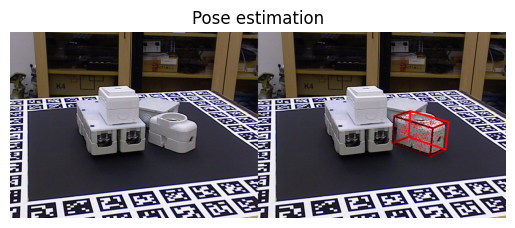

In [21]:
plt.imshow(vis_img)
plt.axis('off')
plt.title("Pose estimation")
plt.show()